In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import cv2
import numpy as np
import json
import matplotlib.pyplot as plt
import numpy as np
import h5py
import os
import glob
import scipy.io
import torch
from sklearn.metrics import confusion_matrix
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import numpy as np
import matplotlib.pyplot as plt
# import tensorflow.compat.v1 as tf
import torchvision.transforms as transforms
import pickle
from collections import OrderedDict
import torch
import torch.nn as nn
from torchsummary import summary

In [ ]:
import pickle
file = open('/content/drive/MyDrive/CAPSTONE/Aerocity/train_inp','rb')
final_inp = pickle.load(file)
print(len(final_inp))

# file = open('/content/drive/MyDrive/CAPSTONE/Aerocity/train_rgb','rb')
# final_semantic = pickle.load(file)
# print(len(final_semantic))

file = open("/content/drive/MyDrive/CAPSTONE/Aerocity/train_gt",'rb')
final_gt = pickle.load(file)
print(len(final_gt))

2975
2975


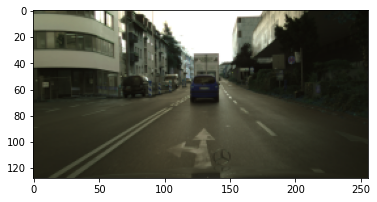

In [ ]:
plt.imshow(final_inp[10])

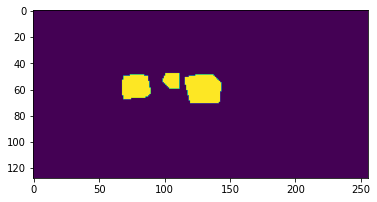

In [ ]:
plt.imshow(final_gt[10][:,:,0])

In [ ]:
final_inp1=final_inp
final_gt1=final_gt

In [ ]:
final_inp=final_inp1[:320]+final_inp1[600:2840]
final_gt=final_gt1[:320]+final_gt1[600:2840]
test_inp=final_inp1[320:576]
test_gt=final_gt1[320:576]
print(len(final_inp))
print(len(final_gt))

print(len(test_inp))
print(len(test_gt))

2560
2560
256
256


In [ ]:
class UNet(nn.Module):

    def __init__(self, in_channels=3, out_channels=5, init_features=32):
        super(UNet, self).__init__()

        features = init_features
        self.encoder1 = UNet._block(in_channels, features, name="enc1")
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.encoder2 = UNet._block(features, features * 2, name="enc2")
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.encoder3 = UNet._block(features * 2, features * 4, name="enc3")
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.encoder4 = UNet._block(features * 4, features * 8, name="enc4")
        self.pool4 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.bottleneck = UNet._block(features * 8, features * 16, name="bottleneck")

        self.upconv4 = nn.ConvTranspose2d(
            features * 16, features * 8, kernel_size=2, stride=2
        )
        self.decoder4 = UNet._block((features * 8) * 2, features * 8, name="dec4")
        self.upconv3 = nn.ConvTranspose2d(
            features * 8, features * 4, kernel_size=2, stride=2
        )
        self.decoder3 = UNet._block((features * 4) * 2, features * 4, name="dec3")
        self.upconv2 = nn.ConvTranspose2d(
            features * 4, features * 2, kernel_size=2, stride=2
        )
        self.decoder2 = UNet._block((features * 2) * 2, features * 2, name="dec2")
        self.upconv1 = nn.ConvTranspose2d(
            features * 2, features, kernel_size=2, stride=2
        )
        self.decoder1 = UNet._block(features * 2, features, name="dec1")

        self.conv = nn.Conv2d(
            in_channels=features, out_channels=out_channels, kernel_size=1
        )

    def forward(self, x):
        enc1 = self.encoder1(x)
        enc2 = self.encoder2(self.pool1(enc1))
        enc3 = self.encoder3(self.pool2(enc2))
        enc4 = self.encoder4(self.pool3(enc3))

        bottleneck = self.bottleneck(self.pool4(enc4))

        dec4 = self.upconv4(bottleneck)
        dec4 = torch.cat((dec4, enc4), dim=1)
        dec4 = self.decoder4(dec4)
        dec3 = self.upconv3(dec4)
        dec3 = torch.cat((dec3, enc3), dim=1)
        dec3 = self.decoder3(dec3)
        dec2 = self.upconv2(dec3)
        dec2 = torch.cat((dec2, enc2), dim=1)
        dec2 = self.decoder2(dec2)
        dec1 = self.upconv1(dec2)
        dec1 = torch.cat((dec1, enc1), dim=1)
        dec1 = self.decoder1(dec1)
        return F.softmax(self.conv(dec1))

    @staticmethod
    def _block(in_channels, features, name):
        return nn.Sequential(
            OrderedDict(
                [
                    (
                        name + "conv1",
                        nn.Conv2d(
                            in_channels=in_channels,
                            out_channels=features,
                            kernel_size=3,
                            padding=1,
                            bias=False,
                        ),
                    ),
                    (name + "norm1", nn.BatchNorm2d(num_features=features)),
                    (name + "relu1", nn.ReLU(inplace=True)),
                    (
                        name + "conv2",
                        nn.Conv2d(
                            in_channels=features,
                            out_channels=features,
                            kernel_size=3,
                            padding=1,
                            bias=False,
                        ),
                    ),
                    (name + "norm2", nn.BatchNorm2d(num_features=features)),
                    (name + "relu2", nn.ReLU(inplace=True)),
                ]
            )
        )


In [ ]:
class SegNet(nn.Module):
    
    def __init__(self):
        super(SegNet, self).__init__()
        
        self.conv1_1 = nn.Conv2d(in_channels=3, out_channels=64, kernel_size = 3, stride = 1, padding = 1)
        self.conv1_2 = nn.Conv2d(64, 64, kernel_size = 3, stride = 1, padding = 1)
        self.conv2_1 = nn.Conv2d(64, 128, kernel_size = 3, stride = 1, padding = 1)
        self.conv2_2 = nn.Conv2d(128, 128, kernel_size = 3, stride = 1, padding = 1)
        self.conv3_1 = nn.Conv2d(128, 256, kernel_size = 3, stride = 1, padding = 1)
        self.conv3_2 = nn.Conv2d(256, 256, kernel_size = 3, stride = 1, padding = 1)
        self.conv3_3 = nn.Conv2d(256, 256, kernel_size = 3, stride = 1, padding = 1)
        self.conv4_1 = nn.Conv2d(256, 512, kernel_size = 3, stride = 1, padding = 1)
        self.conv4_2 = nn.Conv2d(512, 512, kernel_size = 3, stride = 1, padding = 1)
        self.conv4_3 = nn.Conv2d(512, 512, kernel_size = 3, stride = 1, padding = 1)
        self.conv5_1 = nn.Conv2d(512, 512, kernel_size = 3, stride = 1, padding = 1)
        self.conv5_2 = nn.Conv2d(512, 512, kernel_size = 3, stride = 1, padding = 1)
        self.conv5_3 = nn.Conv2d(512, 512, kernel_size = 3, stride = 1, padding = 1)

        self.pool1 = nn.MaxPool2d(kernel_size = 2, stride = 2, padding = 0, return_indices = True)
        self.pool2 = nn.MaxPool2d(kernel_size = 2, stride = 2, padding = 0, return_indices = True)
        self.pool3 = nn.MaxPool2d(kernel_size = 2, stride = 2, padding = 0, return_indices = True)
        self.pool4 = nn.MaxPool2d(kernel_size = 2, stride = 2, padding = 0, return_indices = True)
        self.pool5 = nn.MaxPool2d(kernel_size = 2, stride = 2, padding = 0, return_indices = True)
        
        self.unpool5 = nn.MaxUnpool2d(kernel_size = 2, stride = 2, padding = 0)
        self.unpool4 = nn.MaxUnpool2d(kernel_size = 2, stride = 2, padding = 0)
        self.unpool3 = nn.MaxUnpool2d(kernel_size = 2, stride = 2, padding = 0)
        self.unpool2 = nn.MaxUnpool2d(kernel_size = 2, stride = 2, padding = 0)
        self.unpool1 = nn.MaxUnpool2d(kernel_size = 2, stride = 2, padding = 0)

        self.deconv5_1 = nn.ConvTranspose2d(512, 512, kernel_size = 3, stride = 1, padding = 1)
        self.deconv5_2 = nn.ConvTranspose2d(512, 512, kernel_size = 3, stride = 1, padding = 1)
        self.deconv5_3 = nn.ConvTranspose2d(512, 512, kernel_size = 3, stride = 1, padding = 1)
        self.deconv4_1 = nn.ConvTranspose2d(512, 512, kernel_size = 3, stride = 1, padding = 1)
        self.deconv4_2 = nn.ConvTranspose2d(512, 512, kernel_size = 3, stride = 1, padding = 1)
        self.deconv4_3 = nn.ConvTranspose2d(512, 256, kernel_size = 3, stride = 1, padding = 1)
        self.deconv3_1 = nn.ConvTranspose2d(256, 256, kernel_size = 3, stride = 1, padding = 1)
        self.deconv3_2 = nn.ConvTranspose2d(256, 256, kernel_size = 3, stride = 1, padding = 1)
        self.deconv3_3 = nn.ConvTranspose2d(256, 128, kernel_size = 3, stride = 1, padding = 1)
        self.deconv2_1 = nn.ConvTranspose2d(128, 128, kernel_size = 3, stride = 1, padding = 1)
        self.deconv2_2 = nn.ConvTranspose2d(128, 64, kernel_size = 3, stride = 1, padding = 1)
        self.deconv1_1 = nn.ConvTranspose2d(64, 64, kernel_size = 3, stride = 1, padding = 1)
        self.deconv1_2 = nn.ConvTranspose2d(64, 5, kernel_size = 3, stride = 1, padding = 1)

        self.batch_norm1 = nn.BatchNorm2d(64)
        self.batch_norm2 = nn.BatchNorm2d(128)
        self.batch_norm3 = nn.BatchNorm2d(256)
        self.batch_norm4 = nn.BatchNorm2d(512)

        self.conv_end = nn.Conv2d(in_channels=1, out_channels=3, kernel_size = 1, stride = 1, padding = 0)
        # self.softmax = nn.Softmax(dim=-1)
    
    def forward(self, x):
        
        size_1 = x.size()
        x = self.conv1_1(x)
        x = self.batch_norm1(x)
        x = F.relu(x)
        x = self.conv1_2(x)
        x = self.batch_norm1(x)
        x = F.relu(x)
        x, idxs1 = self.pool1(x)
        
        size_2 = x.size()
        x = self.conv2_1(x)
        x = self.batch_norm2(x)
        x = F.relu(x)
        x = self.conv2_2(x)
        x = self.batch_norm2(x)
        x = F.relu(x)
        x, idxs2 = self.pool2(x)
        
        size_3 = x.size()
        x = self.conv3_1(x)
        x = self.batch_norm3(x)
        x = F.relu(x)
        x = self.conv3_2(x)
        x = self.batch_norm3(x)
        x = F.relu(x)
        x = self.conv3_3(x)
        x = self.batch_norm3(x)
        x = F.relu(x)
        x, idxs3 = self.pool3(x)
        
        size_4 = x.size()
        x = self.conv4_1(x)
        x = self.batch_norm4(x)
        x = F.relu(x)
        x = self.conv4_2(x)
        x = self.batch_norm4(x)
        x = F.relu(x)
        x = self.conv4_3(x)
        x = self.batch_norm4(x)
        x = F.relu(x)
        x, idxs4 = self.pool4(x)
        
        size_5 = x.size()
        x = self.conv5_1(x)
        x = self.batch_norm4(x)
        x = F.relu(x)
        x = self.conv5_2(x)
        x = self.batch_norm4(x)
        x = F.relu(x)
        x = self.conv5_3(x)
        # print(x.shape)
        x = self.batch_norm4(x)
        x = F.relu(x)
        x, idxs5 = self.pool5(x)

        
        x = self.unpool5(x, idxs5, output_size = size_5)
        # print(x.shape)
        x = self.deconv5_1(x)
        # print(x.shape)
        x = self.batch_norm4(x)
        x = F.relu(x)
        x = self.deconv5_2(x)
        # print(x.shape)
        x = self.batch_norm4(x)
        x = F.relu(x)
        x = self.deconv5_3(x)
        # print(x.shape)
        x = self.batch_norm4(x)
        x = F.relu(x)
        
        x = self.unpool4(x, idxs4, output_size = size_4)
        # print(x.shape)
        x = self.deconv4_1(x)
        x = self.batch_norm4(x)
        x = F.relu(x)
        # print(x.shape)
        x = self.deconv4_2(x)
        x = self.batch_norm4(x)
        x = F.relu(x)
        # print(x.shape)
        x = self.deconv4_3(x)
        # print(x.shape)
        x = self.batch_norm3(x)
        x = F.relu(x)
        
        x = self.unpool3(x, idxs3, output_size = size_3)
        x = self.deconv3_1(x)
        x = self.batch_norm3(x)
        x = F.relu(x)
        x = self.deconv3_2(x)
        x = self.batch_norm3(x)
        x = F.relu(x)
        x = self.deconv3_3(x)
        x = self.batch_norm2(x)
        x = F.relu(x)
        
        x = self.unpool2(x, idxs2, output_size = size_2)
        x = self.deconv2_1(x)
        x = self.batch_norm2(x)
        x = F.relu(x)
        x = self.deconv2_2(x)
        x = self.batch_norm1(x)
        x = F.relu(x)
        
        x = self.unpool1(x, idxs1, output_size = size_1)
        x = self.deconv1_1(x)
        x = self.batch_norm1(x)
        x = F.relu(x)
        x = self.deconv1_2(x)
        x = F.softmax(x)

        return x

In [ ]:
class USegNet(nn.Module):  
    def __init__(self):
        super(USegNet, self).__init__()
        self.conv1_1 = nn.Conv2d(in_channels=3, out_channels=64, kernel_size = 3, stride = 1, padding = 1)
        self.conv1_2 = nn.Conv2d(64, 64, kernel_size = 3, stride = 1, padding = 1)
        self.conv2_1 = nn.Conv2d(64, 128, kernel_size = 3, stride = 1, padding = 1)
        self.conv2_2 = nn.Conv2d(128, 128, kernel_size = 3, stride = 1, padding = 1)
        self.conv3_1 = nn.Conv2d(128, 256, kernel_size = 3, stride = 1, padding = 1)
        self.conv3_2 = nn.Conv2d(256, 256, kernel_size = 3, stride = 1, padding = 1)
        self.conv3_3 = nn.Conv2d(256, 256, kernel_size = 3, stride = 1, padding = 1)

        self.pool1 = nn.MaxPool2d(kernel_size = 2, stride = 2, padding = 0, return_indices = True)
        self.pool2 = nn.MaxPool2d(kernel_size = 2, stride = 2, padding = 0, return_indices = True)
        self.pool3 = nn.MaxPool2d(kernel_size = 2, stride = 2, padding = 0, return_indices = True)

        self.unpool3 = nn.MaxUnpool2d(kernel_size = 2, stride = 2, padding = 0)
        self.unpool2 = nn.MaxUnpool2d(kernel_size = 2, stride = 2, padding = 0)
        self.unpool1 = nn.MaxUnpool2d(kernel_size = 2, stride = 2, padding = 0)

        self.deconv3_1 = nn.Conv2d(256, 256, kernel_size = 3, stride = 1, padding = 1)
        self.deconv3_2 = nn.Conv2d(256, 256, kernel_size = 3, stride = 1, padding = 1)
        self.deconv3_3 = nn.Conv2d(256, 128, kernel_size = 3, stride = 1, padding = 1)
        self.deconv2_1 = nn.Conv2d(128, 128, kernel_size = 3, stride = 1, padding = 1)
        self.deconv2_2 = nn.Conv2d(128, 64, kernel_size = 3, stride = 1, padding = 1)
        self.deconv1_1 = nn.Conv2d(128, 64, kernel_size = 3, stride = 1, padding = 1)
        self.deconv1_2 = nn.Conv2d(64, 5, kernel_size = 3, stride = 1, padding = 1)
        
        self.batch_norm1 = nn.BatchNorm2d(64)
        self.batch_norm2 = nn.BatchNorm2d(128)
        self.batch_norm3 = nn.BatchNorm2d(256)
        self.batch_norm4 = nn.BatchNorm2d(512)

        self.conv_end = nn.Conv2d(in_channels=1, out_channels=5, kernel_size = 1, stride = 1, padding = 0)
    
    def forward(self, x):
        
        size_1 = x.size()
        x = self.conv1_1(x)
        x = self.batch_norm1(x)
        x = F.relu(x)
        x = self.conv1_2(x)
        x = self.batch_norm1(x)
        x = F.relu(x)
        y=x
        x, idxs1 = self.pool1(x)
        # print ("hello",idxs1)
        
        size_2 = x.size()
        x = self.conv2_1(x)
        x = self.batch_norm2(x)
        x = F.relu(x)
        x = self.conv2_2(x)
        x = self.batch_norm2(x)
        x = F.relu(x)
        x, idxs2 = self.pool2(x)
        size_3 = x.size()
        x = self.conv3_1(x)
        x = self.batch_norm3(x)
        x = F.relu(x)
        x = self.conv3_2(x)
        x = self.batch_norm3(x)
        x = F.relu(x)
        x = self.conv3_3(x)
        x = self.batch_norm3(x)
        x = F.relu(x)
        x, idxs3 = self.pool3(x)
       
        x = self.unpool3(x, idxs3, output_size = size_3)
        x = self.deconv3_1(x)
        x = self.batch_norm3(x)
        x = F.relu(x)
        x = self.deconv3_2(x)
        x = self.batch_norm3(x)
        x = F.relu(x)
        x = self.deconv3_3(x)
        x = self.batch_norm2(x)
        x = F.relu(x)
        x = self.unpool2(x, idxs2, output_size = size_2)
        x = self.deconv2_1(x)
        x = self.batch_norm2(x)
        x = F.relu(x)
        x = self.deconv2_2(x)
        x = self.batch_norm1(x)
        x = F.relu(x)
        x = self.unpool1(x, idxs1, output_size = size_1)
        x= torch.cat((x,y),1)
        x = self.deconv1_1(x)
        x = self.batch_norm1(x)
        x = F.relu(x)
        x =F.softmax(self.deconv1_2(x))

        return x

In [ ]:
class USegNet_withoutskip(nn.Module):  #Reduced Segnet
    def __init__(self):
        super(USegNet_withoutskip, self).__init__()
        self.conv1_1 = nn.Conv2d(in_channels=3, out_channels=64, kernel_size = 3, stride = 1, padding = 1)
        self.conv1_2 = nn.Conv2d(64, 64, kernel_size = 3, stride = 1, padding = 1)
        self.conv2_1 = nn.Conv2d(64, 128, kernel_size = 3, stride = 1, padding = 1)
        self.conv2_2 = nn.Conv2d(128, 128, kernel_size = 3, stride = 1, padding = 1)
        self.conv3_1 = nn.Conv2d(128, 256, kernel_size = 3, stride = 1, padding = 1)
        self.conv3_2 = nn.Conv2d(256, 256, kernel_size = 3, stride = 1, padding = 1)
        self.conv3_3 = nn.Conv2d(256, 256, kernel_size = 3, stride = 1, padding = 1)

        self.pool1 = nn.MaxPool2d(kernel_size = 2, stride = 2, padding = 0, return_indices = True)
        self.pool2 = nn.MaxPool2d(kernel_size = 2, stride = 2, padding = 0, return_indices = True)
        self.pool3 = nn.MaxPool2d(kernel_size = 2, stride = 2, padding = 0, return_indices = True)

        self.unpool3 = nn.MaxUnpool2d(kernel_size = 2, stride = 2, padding = 0)
        self.unpool2 = nn.MaxUnpool2d(kernel_size = 2, stride = 2, padding = 0)
        self.unpool1 = nn.MaxUnpool2d(kernel_size = 2, stride = 2, padding = 0)

        self.deconv3_1 = nn.Conv2d(256, 256, kernel_size = 3, stride = 1, padding = 1)
        self.deconv3_2 = nn.Conv2d(256, 256, kernel_size = 3, stride = 1, padding = 1)
        self.deconv3_3 = nn.Conv2d(256, 128, kernel_size = 3, stride = 1, padding = 1)
        self.deconv2_1 = nn.Conv2d(128, 128, kernel_size = 3, stride = 1, padding = 1)
        self.deconv2_2 = nn.Conv2d(128, 64, kernel_size = 3, stride = 1, padding = 1)
        self.deconv1_1 = nn.Conv2d(64, 64, kernel_size = 3, stride = 1, padding = 1)
        self.deconv1_2 = nn.Conv2d(64, 5, kernel_size = 3, stride = 1, padding = 1)

        # self.skip = torch.cat((first_tensor, second_tensor), 0)


        self.batch_norm1 = nn.BatchNorm2d(64)
        self.batch_norm2 = nn.BatchNorm2d(128)
        self.batch_norm3 = nn.BatchNorm2d(256)
        self.batch_norm4 = nn.BatchNorm2d(512)

        self.conv_end = nn.Conv2d(in_channels=1, out_channels=5, kernel_size = 1, stride = 1, padding = 0)
        # self.softmax = nn.Softmax(dim=-1)
    
    def forward(self, x):
        
        size_1 = x.size()
        x = self.conv1_1(x)
        x = self.batch_norm1(x)
        x = F.relu(x)
        x = self.conv1_2(x)
        x = self.batch_norm1(x)
        x = F.relu(x)
        x, idxs1 = self.pool1(x)
        # print ("hello",idxs1)
        
        size_2 = x.size()
        x = self.conv2_1(x)
        x = self.batch_norm2(x)
        x = F.relu(x)
        x = self.conv2_2(x)
        x = self.batch_norm2(x)
        x = F.relu(x)
        x, idxs2 = self.pool2(x)
       
        # print ("hi",idxs2)
        
        size_3 = x.size()
        x = self.conv3_1(x)
        x = self.batch_norm3(x)
        x = F.relu(x)
        x = self.conv3_2(x)
        x = self.batch_norm3(x)
        x = F.relu(x)
        x = self.conv3_3(x)
        x = self.batch_norm3(x)
        x = F.relu(x)
        x, idxs3 = self.pool3(x)
       
        x = self.unpool3(x, idxs3, output_size = size_3)
        x = self.deconv3_1(x)
        x = self.batch_norm3(x)
        x = F.relu(x)
        x = self.deconv3_2(x)
        x = self.batch_norm3(x)
        x = F.relu(x)
        x = self.deconv3_3(x)
        x = self.batch_norm2(x)
        x = F.relu(x)
        
        x = self.unpool2(x, idxs2, output_size = size_2)
        x = self.deconv2_1(x)
        x = self.batch_norm2(x)
        x = F.relu(x)
        x = self.deconv2_2(x)
        x = self.batch_norm1(x)
        x = F.relu(x)
        
        x = self.unpool1(x, idxs1, output_size = size_1)

        x = self.deconv1_1(x)
        x = self.batch_norm1(x)
        x = F.relu(x)
        x =F.softmax(self.deconv1_2(x))

        return x

In [ ]:
class USegNet_Residual(nn.Module):  
    def __init__(self):
        super(USegNet_Residual, self).__init__()
        self.conv1_1 = nn.Conv2d(in_channels=3, out_channels=64, kernel_size = 3, stride = 1, padding = 1)
        self.conv1_2 = nn.Conv2d(64, 64, kernel_size = 3, stride = 1, padding = 1)
        self.conv2_1 = nn.Conv2d(64, 128, kernel_size = 3, stride = 1, padding = 1)
        self.conv2_2 = nn.Conv2d(128, 128, kernel_size = 3, stride = 1, padding = 1)
        self.conv3_1 = nn.Conv2d(128, 256, kernel_size = 3, stride = 1, padding = 1)
        self.conv3_2 = nn.Conv2d(256, 256, kernel_size = 3, stride = 1, padding = 1)
        self.conv3_3 = nn.Conv2d(256, 256, kernel_size = 3, stride = 1, padding = 1)

        self.pool1 = nn.MaxPool2d(kernel_size = 2, stride = 2, padding = 0, return_indices = True)
        self.pool2 = nn.MaxPool2d(kernel_size = 2, stride = 2, padding = 0, return_indices = True)
        self.pool3 = nn.MaxPool2d(kernel_size = 2, stride = 2, padding = 0, return_indices = True)

        self.unpool3 = nn.MaxUnpool2d(kernel_size = 2, stride = 2, padding = 0)
        self.unpool2 = nn.MaxUnpool2d(kernel_size = 2, stride = 2, padding = 0)
        self.unpool1 = nn.MaxUnpool2d(kernel_size = 2, stride = 2, padding = 0)

        self.deconv3_1 = nn.Conv2d(256, 256, kernel_size = 3, stride = 1, padding = 1)
        self.deconv3_2 = nn.Conv2d(256, 256, kernel_size = 3, stride = 1, padding = 1)
        self.deconv3_3 = nn.Conv2d(256, 128, kernel_size = 3, stride = 1, padding = 1)
        self.deconv2_1 = nn.Conv2d(128, 128, kernel_size = 3, stride = 1, padding = 1)
        self.deconv2_2 = nn.Conv2d(128, 64, kernel_size = 3, stride = 1, padding = 1)
        self.deconv1_1 = nn.Conv2d(64, 64, kernel_size = 3, stride = 1, padding = 1)
        self.deconv1_2 = nn.Conv2d(64, 5, kernel_size = 3, stride = 1, padding = 1)

        # self.skip = torch.cat((first_tensor, second_tensor), 0)


        self.batch_norm1 = nn.BatchNorm2d(64)
        self.batch_norm2 = nn.BatchNorm2d(128)
        self.batch_norm3 = nn.BatchNorm2d(256)
        self.batch_norm4 = nn.BatchNorm2d(512)

        self.conv_end = nn.Conv2d(in_channels=1, out_channels=5, kernel_size = 1, stride = 1, padding = 0)
        # self.softmax = nn.Softmax(dim=-1)
    
    def forward(self, x):
        
        size_1 = x.size()
        x = self.conv1_1(x)
        x = self.batch_norm1(x)
        x = F.relu(x)
        x = self.conv1_2(x)
        x = self.batch_norm1(x)
        x = F.relu(x)
        y=x
        x, idxs1 = self.pool1(x)
        # print ("hello",idxs1)
        
        size_2 = x.size()
        x = self.conv2_1(x)
        x = self.batch_norm2(x)
        x = F.relu(x)
        x = self.conv2_2(x)
        x = self.batch_norm2(x)
        x = F.relu(x)
        x, idxs2 = self.pool2(x)
       
        # print ("hi",idxs2)
        
        size_3 = x.size()
        x = self.conv3_1(x)
        x = self.batch_norm3(x)
        x = F.relu(x)
        x = self.conv3_2(x)
        x = self.batch_norm3(x)
        x = F.relu(x)
        x = self.conv3_3(x)
        x = self.batch_norm3(x)
        x = F.relu(x)
        x, idxs3 = self.pool3(x)
       
        x = self.unpool3(x, idxs3, output_size = size_3)
        x = self.deconv3_1(x)
        x = self.batch_norm3(x)
        x = F.relu(x)
        x = self.deconv3_2(x)
        x = self.batch_norm3(x)
        x = F.relu(x)
        x = self.deconv3_3(x)
        x = self.batch_norm2(x)
        x = F.relu(x)
        
        x = self.unpool2(x, idxs2, output_size = size_2)
        x = self.deconv2_1(x)
        x = self.batch_norm2(x)
        x = F.relu(x)
        x = self.deconv2_2(x)
        x = self.batch_norm1(x)
        x = F.relu(x)
        
        x = self.unpool1(x, idxs1, output_size = size_1)

        # print (x.shape)
        # print(y.shape)
        x=x+y
       
        x = self.deconv1_1(x)
        x = self.batch_norm1(x)
        x = F.relu(x)
        x =F.softmax(self.deconv1_2(x))
        return x

In [ ]:
class USegNet_dense(nn.Module):  
    def __init__(self):
        super(USegNet_dense, self).__init__()
        self.conv1_1 = nn.Conv2d(in_channels=3, out_channels=64, kernel_size = 3, stride = 1, padding = 1)
        self.conv1_2 = nn.Conv2d(64, 64, kernel_size = 3, stride = 1, padding = 1)
        self.conv2_1 = nn.Conv2d(64, 128, kernel_size = 3, stride = 1, padding = 1)
        self.conv2_2 = nn.Conv2d(128, 128, kernel_size = 3, stride = 1, padding = 1)
        self.conv3_1 = nn.Conv2d(128, 256, kernel_size = 3, stride = 1, padding = 1)
        self.conv3_2 = nn.Conv2d(256, 256, kernel_size = 3, stride = 1, padding = 1)
        self.conv3_3 = nn.Conv2d(256, 256, kernel_size = 3, stride = 1, padding = 1)

        self.pool1 = nn.MaxPool2d(kernel_size = 2, stride = 2, padding = 0, return_indices = True)
        self.pool2 = nn.MaxPool2d(kernel_size = 2, stride = 2, padding = 0, return_indices = True)
        self.pool3 = nn.MaxPool2d(kernel_size = 2, stride = 2, padding = 0, return_indices = True)

        self.unpool3 = nn.MaxUnpool2d(kernel_size = 2, stride = 2, padding = 0)
        self.unpool2 = nn.MaxUnpool2d(kernel_size = 2, stride = 2, padding = 0)
        self.unpool1 = nn.MaxUnpool2d(kernel_size = 2, stride = 2, padding = 0)

        self.deconv3_1 = nn.Conv2d(256, 256, kernel_size = 3, stride = 1, padding = 1)
        self.deconv3_2 = nn.Conv2d(256, 256, kernel_size = 3, stride = 1, padding = 1)
        self.deconv3_3 = nn.Conv2d(256, 128, kernel_size = 3, stride = 1, padding = 1)
        self.deconv2_1 = nn.Conv2d(256, 128, kernel_size = 3, stride = 1, padding = 1)
        self.deconv2_2 = nn.Conv2d(128, 64, kernel_size = 3, stride = 1, padding = 1)
        self.deconv1_1 = nn.Conv2d(128, 64, kernel_size = 3, stride = 1, padding = 1)
        self.deconv1_2 = nn.Conv2d(64, 5, kernel_size = 3, stride = 1, padding = 1)

        # self.skip = torch.cat((first_tensor, second_tensor), 0)


        self.batch_norm1 = nn.BatchNorm2d(64)
        self.batch_norm2 = nn.BatchNorm2d(128)
        self.batch_norm3 = nn.BatchNorm2d(256)
        self.batch_norm4 = nn.BatchNorm2d(512)

        self.conv_end = nn.Conv2d(in_channels=1, out_channels=5, kernel_size = 1, stride = 1, padding = 0)
        # self.softmax = nn.Softmax(dim=-1)
    
    def forward(self, x):
        
        size_1 = x.size()
        x = self.conv1_1(x)
        x = self.batch_norm1(x)
        x = F.relu(x)
        x = self.conv1_2(x)
        x = self.batch_norm1(x)
        x = F.relu(x)
        y1=x
        x, idxs1 = self.pool1(x)
        # print ("hello",idxs1)
        
        size_2 = x.size()
        x = self.conv2_1(x)
        x = self.batch_norm2(x)
        x = F.relu(x)
        x = self.conv2_2(x)
        x = self.batch_norm2(x)
        x = F.relu(x)
        y2=x
        x, idxs2 = self.pool2(x)
       
        # print ("hi",idxs2)
        
        size_3 = x.size()
        x = self.conv3_1(x)
        x = self.batch_norm3(x)
        x = F.relu(x)
        x = self.conv3_2(x)
        x = self.batch_norm3(x)
        x = F.relu(x)
        x = self.conv3_3(x)
        x = self.batch_norm3(x)
        x = F.relu(x)
        y3=x
        x, idxs3 = self.pool3(x)
       
        x = self.unpool3(x, idxs3, output_size = size_3)
        x = self.deconv3_1(x)
        x = self.batch_norm3(x)
        x = F.relu(x)
        x = self.deconv3_2(x)
        x = self.batch_norm3(x)
        x = F.relu(x)
        x = self.deconv3_3(x)
        x = self.batch_norm2(x)
        x = F.relu(x)
        x = self.unpool2(x, idxs2, output_size = size_2)
        x= torch.cat((x,y2),1)

        x = self.deconv2_1(x)
        x = self.batch_norm2(x)
        x = F.relu(x)
        x = self.deconv2_2(x)
        x = self.batch_norm1(x)
        x = F.relu(x)
        
        x = self.unpool1(x, idxs1, output_size = size_1)
        x= torch.cat((x,y1),1)
       
        x = self.deconv1_1(x)
        x = self.batch_norm1(x)
        x = F.relu(x)
        x =F.softmax(self.deconv1_2(x))

        return x

In [ ]:
class USegNet_transConv(nn.Module):  
    def __init__(self):
        super(USegNet_transConv, self).__init__()
        self.conv1_1 = nn.Conv2d(in_channels=3, out_channels=64, kernel_size = 3, stride = 1, padding = 1)
        self.conv1_2 = nn.Conv2d(64, 64, kernel_size = 3, stride = 1, padding = 1)
        self.conv2_1 = nn.Conv2d(64, 128, kernel_size = 3, stride = 1, padding = 1)
        self.conv2_2 = nn.Conv2d(128, 128, kernel_size = 3, stride = 1, padding = 1)
        self.conv3_1 = nn.Conv2d(128, 256, kernel_size = 3, stride = 1, padding = 1)
        self.conv3_2 = nn.Conv2d(256, 256, kernel_size = 3, stride = 1, padding = 1)
        self.conv3_3 = nn.Conv2d(256, 256, kernel_size = 3, stride = 1, padding = 1)

        self.pool1 = nn.MaxPool2d(kernel_size = 2, stride = 2, padding = 0, return_indices = True)
        self.pool2 = nn.MaxPool2d(kernel_size = 2, stride = 2, padding = 0, return_indices = True)
        self.pool3 = nn.MaxPool2d(kernel_size = 2, stride = 2, padding = 0, return_indices = True)

        self.unpool3 = nn.ConvTranspose2d(256, 256, kernel_size = 2, stride = 2, padding = 0)
        self.unpool2 = nn.ConvTranspose2d(128, 128, kernel_size = 2, stride = 2, padding = 0)
        self.unpool1 = nn.ConvTranspose2d(64, 64, kernel_size = 2, stride = 2, padding = 0)

        self.deconv3_1 = nn.Conv2d(256, 256, kernel_size = 3, stride = 1, padding = 1)
        self.deconv3_2 = nn.Conv2d(256, 256, kernel_size = 3, stride = 1, padding = 1)
        self.deconv3_3 = nn.Conv2d(256, 128, kernel_size = 3, stride = 1, padding = 1)
        self.deconv2_1 = nn.Conv2d(128, 128, kernel_size = 3, stride = 1, padding = 1)
        self.deconv2_2 = nn.Conv2d(128, 64, kernel_size = 3, stride = 1, padding = 1)
        self.deconv1_1 = nn.Conv2d(128, 64, kernel_size = 3, stride = 1, padding = 1)
        self.deconv1_2 = nn.Conv2d(64, 5, kernel_size = 3, stride = 1, padding = 1)

        # self.skip = torch.cat((first_tensor, second_tensor), 0)


        self.batch_norm1 = nn.BatchNorm2d(64)
        self.batch_norm2 = nn.BatchNorm2d(128)
        self.batch_norm3 = nn.BatchNorm2d(256)
        self.batch_norm4 = nn.BatchNorm2d(512)

        self.conv_end = nn.Conv2d(in_channels=1, out_channels=5, kernel_size = 1, stride = 1, padding = 0)
        # self.softmax = nn.Softmax(dim=-1)
    
    def forward(self, x):
        
        size_1 = x.size()
        x = self.conv1_1(x)
        x = self.batch_norm1(x)
        x = F.relu(x)
        x = self.conv1_2(x)
        x = self.batch_norm1(x)
        x = F.relu(x)
        y=x
        x, idxs1 = self.pool1(x)
        # print ("hello",idxs1)
        
        size_2 = x.size()
        x = self.conv2_1(x)
        x = self.batch_norm2(x)
        x = F.relu(x)
        x = self.conv2_2(x)
        x = self.batch_norm2(x)
        x = F.relu(x)
        x, idxs2 = self.pool2(x)
       
        # print ("hi",idxs2)
        
        size_3 = x.size()
        x = self.conv3_1(x)
        x = self.batch_norm3(x)
        x = F.relu(x)
        x = self.conv3_2(x)
        x = self.batch_norm3(x)
        x = F.relu(x)
        x = self.conv3_3(x)
        x = self.batch_norm3(x)
        x = F.relu(x)
        x, idxs3 = self.pool3(x)
       
        x = self.unpool3(x)
        x = self.deconv3_1(x)
        x = self.batch_norm3(x)
        x = F.relu(x)
        x = self.deconv3_2(x)
        x = self.batch_norm3(x)
        x = F.relu(x)
        x = self.deconv3_3(x)
        x = self.batch_norm2(x)
        x = F.relu(x)
        
        x = self.unpool2(x)
        x = self.deconv2_1(x)
        x = self.batch_norm2(x)
        x = F.relu(x)
        x = self.deconv2_2(x)
        x = self.batch_norm1(x)
        x = F.relu(x)
        
        x = self.unpool1(x)

        # print (x.shape)
        # print(y.shape)
        x= torch.cat((x,y),1)
       
        x = self.deconv1_1(x)
        x = self.batch_norm1(x)
        x = F.relu(x)
        x =F.softmax(self.deconv1_2(x))


        return x

In [ ]:
class USegNet_trans_without_skip(nn.Module):  
    def __init__(self):
        super(USegNet_trans_without_skip, self).__init__()
        self.conv1_1 = nn.Conv2d(in_channels=3, out_channels=64, kernel_size = 3, stride = 1, padding = 1)
        self.conv1_2 = nn.Conv2d(64, 64, kernel_size = 3, stride = 1, padding = 1)
        self.conv2_1 = nn.Conv2d(64, 128, kernel_size = 3, stride = 1, padding = 1)
        self.conv2_2 = nn.Conv2d(128, 128, kernel_size = 3, stride = 1, padding = 1)
        self.conv3_1 = nn.Conv2d(128, 256, kernel_size = 3, stride = 1, padding = 1)
        self.conv3_2 = nn.Conv2d(256, 256, kernel_size = 3, stride = 1, padding = 1)
        self.conv3_3 = nn.Conv2d(256, 256, kernel_size = 3, stride = 1, padding = 1)

        self.pool1 = nn.MaxPool2d(kernel_size = 2, stride = 2, padding = 0, return_indices = True)
        self.pool2 = nn.MaxPool2d(kernel_size = 2, stride = 2, padding = 0, return_indices = True)
        self.pool3 = nn.MaxPool2d(kernel_size = 2, stride = 2, padding = 0, return_indices = True)

        self.unpool3 = nn.ConvTranspose2d(256, 256, kernel_size = 2, stride = 2, padding = 0)
        self.unpool2 = nn.ConvTranspose2d(128, 128, kernel_size = 2, stride = 2, padding = 0)
        self.unpool1 = nn.ConvTranspose2d(64, 64, kernel_size = 2, stride = 2, padding = 0)

        self.deconv3_1 = nn.Conv2d(256, 256, kernel_size = 3, stride = 1, padding = 1)
        self.deconv3_2 = nn.Conv2d(256, 256, kernel_size = 3, stride = 1, padding = 1)
        self.deconv3_3 = nn.Conv2d(256, 128, kernel_size = 3, stride = 1, padding = 1)
        self.deconv2_1 = nn.Conv2d(128, 128, kernel_size = 3, stride = 1, padding = 1)
        self.deconv2_2 = nn.Conv2d(128, 64, kernel_size = 3, stride = 1, padding = 1)
        self.deconv1_1 = nn.Conv2d(64, 64, kernel_size = 3, stride = 1, padding = 1)
        self.deconv1_2 = nn.Conv2d(64, 5, kernel_size = 3, stride = 1, padding = 1)

        # self.skip = torch.cat((first_tensor, second_tensor), 0)


        self.batch_norm1 = nn.BatchNorm2d(64)
        self.batch_norm2 = nn.BatchNorm2d(128)
        self.batch_norm3 = nn.BatchNorm2d(256)
        self.batch_norm4 = nn.BatchNorm2d(512)

        self.conv_end = nn.Conv2d(in_channels=1, out_channels=5, kernel_size = 1, stride = 1, padding = 0)
        # self.softmax = nn.Softmax(dim=-1)
    
    def forward(self, x):
        
        size_1 = x.size()
        x = self.conv1_1(x)
        x = self.batch_norm1(x)
        x = F.relu(x)
        x = self.conv1_2(x)
        x = self.batch_norm1(x)
        x = F.relu(x)
        y1=x
        x, idxs1 = self.pool1(x)
        # print ("hello",idxs1)
        
        size_2 = x.size()
        x = self.conv2_1(x)
        x = self.batch_norm2(x)
        x = F.relu(x)
        x = self.conv2_2(x)
        x = self.batch_norm2(x)
        x = F.relu(x)
        y2=x
        x, idxs2 = self.pool2(x)
       
        # print ("hi",idxs2)
        
        size_3 = x.size()
        x = self.conv3_1(x)
        x = self.batch_norm3(x)
        x = F.relu(x)
        x = self.conv3_2(x)
        x = self.batch_norm3(x)
        x = F.relu(x)
        x = self.conv3_3(x)
        x = self.batch_norm3(x)
        x = F.relu(x)
        y3=x
        x, idxs3 = self.pool3(x)
       
        x = self.unpool3(x)
        x = self.deconv3_1(x)
        x = self.batch_norm3(x)
        x = F.relu(x)
        x = self.deconv3_2(x)
        x = self.batch_norm3(x)
        x = F.relu(x)
        x = self.deconv3_3(x)
        x = self.batch_norm2(x)
        x = F.relu(x)
        
        x = self.unpool2(x)
  
        x = self.deconv2_1(x)
        x = self.batch_norm2(x)
        x = F.relu(x)
        x = self.deconv2_2(x)
        x = self.batch_norm1(x)
        x = F.relu(x)
        
        x = self.unpool1(x)
       
        x = self.deconv1_1(x)
        x = self.batch_norm1(x)
        x = F.relu(x)
        x =F.softmax(self.deconv1_2(x))
        return x

In [ ]:
class USegNet_dense_transConv(nn.Module):  
    def __init__(self):
        super(USegNet_dense_transConv, self).__init__()
        self.conv1_1 = nn.Conv2d(in_channels=3, out_channels=64, kernel_size = 3, stride = 1, padding = 1)
        self.conv1_2 = nn.Conv2d(64, 64, kernel_size = 3, stride = 1, padding = 1)
        self.conv2_1 = nn.Conv2d(64, 128, kernel_size = 3, stride = 1, padding = 1)
        self.conv2_2 = nn.Conv2d(128, 128, kernel_size = 3, stride = 1, padding = 1)
        self.conv3_1 = nn.Conv2d(128, 256, kernel_size = 3, stride = 1, padding = 1)
        self.conv3_2 = nn.Conv2d(256, 256, kernel_size = 3, stride = 1, padding = 1)
        self.conv3_3 = nn.Conv2d(256, 256, kernel_size = 3, stride = 1, padding = 1)

        self.pool1 = nn.MaxPool2d(kernel_size = 2, stride = 2, padding = 0, return_indices = True)
        self.pool2 = nn.MaxPool2d(kernel_size = 2, stride = 2, padding = 0, return_indices = True)
        self.pool3 = nn.MaxPool2d(kernel_size = 2, stride = 2, padding = 0, return_indices = True)

        self.unpool3 = nn.ConvTranspose2d(256, 256, kernel_size = 2, stride = 2, padding = 0)
        self.unpool2 = nn.ConvTranspose2d(128, 128, kernel_size = 2, stride = 2, padding = 0)
        self.unpool1 = nn.ConvTranspose2d(64, 64, kernel_size = 2, stride = 2, padding = 0)

        self.deconv3_1 = nn.Conv2d(256, 256, kernel_size = 3, stride = 1, padding = 1)
        self.deconv3_2 = nn.Conv2d(256, 256, kernel_size = 3, stride = 1, padding = 1)
        self.deconv3_3 = nn.Conv2d(256, 128, kernel_size = 3, stride = 1, padding = 1)
        self.deconv2_1 = nn.Conv2d(256, 128, kernel_size = 3, stride = 1, padding = 1)
        self.deconv2_2 = nn.Conv2d(128, 64, kernel_size = 3, stride = 1, padding = 1)
        self.deconv1_1 = nn.Conv2d(128, 64, kernel_size = 3, stride = 1, padding = 1)
        self.deconv1_2 = nn.Conv2d(64, 5, kernel_size = 3, stride = 1, padding = 1)

        # self.skip = torch.cat((first_tensor, second_tensor), 0)


        self.batch_norm1 = nn.BatchNorm2d(64)
        self.batch_norm2 = nn.BatchNorm2d(128)
        self.batch_norm3 = nn.BatchNorm2d(256)
        self.batch_norm4 = nn.BatchNorm2d(512)

        self.conv_end = nn.Conv2d(in_channels=1, out_channels=5, kernel_size = 1, stride = 1, padding = 0)
        # self.softmax = nn.Softmax(dim=-1)
    
    def forward(self, x):
        
        size_1 = x.size()
        x = self.conv1_1(x)
        x = self.batch_norm1(x)
        x = F.relu(x)
        x = self.conv1_2(x)
        x = self.batch_norm1(x)
        x = F.relu(x)
        y1=x
        x, idxs1 = self.pool1(x)
        # print ("hello",idxs1)
        
        size_2 = x.size()
        x = self.conv2_1(x)
        x = self.batch_norm2(x)
        x = F.relu(x)
        x = self.conv2_2(x)
        x = self.batch_norm2(x)
        x = F.relu(x)
        y2=x
        x, idxs2 = self.pool2(x)
       
        # print ("hi",idxs2)
        
        size_3 = x.size()
        x = self.conv3_1(x)
        x = self.batch_norm3(x)
        x = F.relu(x)
        x = self.conv3_2(x)
        x = self.batch_norm3(x)
        x = F.relu(x)
        x = self.conv3_3(x)
        x = self.batch_norm3(x)
        x = F.relu(x)
        y3=x
        x, idxs3 = self.pool3(x)
       
        x = self.unpool3(x)
        x = self.deconv3_1(x)
        x = self.batch_norm3(x)
        x = F.relu(x)
        x = self.deconv3_2(x)
        x = self.batch_norm3(x)
        x = F.relu(x)
        x = self.deconv3_3(x)
        x = self.batch_norm2(x)
        x = F.relu(x)
        x = self.unpool2(x)
        x= torch.cat((x,y2),1)

        x = self.deconv2_1(x)
        x = self.batch_norm2(x)
        x = F.relu(x)
        x = self.deconv2_2(x)
        x = self.batch_norm1(x)
        x = F.relu(x)
        
        x = self.unpool1(x)

        x= torch.cat((x,y1),1)
       
        x = self.deconv1_1(x)
        x = self.batch_norm1(x)
        x = F.relu(x)
        x =F.softmax(self.deconv1_2(x))


        return x

In [ ]:
class USegNet_3Residual(nn.Module):  
    def __init__(self):
        super(USegNet_3Residual, self).__init__()
        self.conv1_1 = nn.Conv2d(in_channels=3, out_channels=64, kernel_size = 3, stride = 1, padding = 1)
        self.conv1_2 = nn.Conv2d(64, 64, kernel_size = 3, stride = 1, padding = 1)
        self.conv2_1 = nn.Conv2d(64, 128, kernel_size = 3, stride = 1, padding = 1)
        self.conv2_2 = nn.Conv2d(128, 128, kernel_size = 3, stride = 1, padding = 1)
        self.conv3_1 = nn.Conv2d(128, 256, kernel_size = 3, stride = 1, padding = 1)
        self.conv3_2 = nn.Conv2d(256, 256, kernel_size = 3, stride = 1, padding = 1)
        self.conv3_3 = nn.Conv2d(256, 256, kernel_size = 3, stride = 1, padding = 1)

        self.pool1 = nn.MaxPool2d(kernel_size = 2, stride = 2, padding = 0, return_indices = True)
        self.pool2 = nn.MaxPool2d(kernel_size = 2, stride = 2, padding = 0, return_indices = True)
        self.pool3 = nn.MaxPool2d(kernel_size = 2, stride = 2, padding = 0, return_indices = True)

        self.unpool3 = nn.MaxUnpool2d(kernel_size = 2, stride = 2, padding = 0)
        self.unpool2 = nn.MaxUnpool2d(kernel_size = 2, stride = 2, padding = 0)
        self.unpool1 = nn.MaxUnpool2d(kernel_size = 2, stride = 2, padding = 0)

        self.deconv3_1 = nn.Conv2d(256, 256, kernel_size = 3, stride = 1, padding = 1)
        self.deconv3_2 = nn.Conv2d(256, 256, kernel_size = 3, stride = 1, padding = 1)
        self.deconv3_3 = nn.Conv2d(256, 128, kernel_size = 3, stride = 1, padding = 1)
        self.deconv2_1 = nn.Conv2d(128, 128, kernel_size = 3, stride = 1, padding = 1)
        self.deconv2_2 = nn.Conv2d(128, 64, kernel_size = 3, stride = 1, padding = 1)
        self.deconv1_1 = nn.Conv2d(64, 64, kernel_size = 3, stride = 1, padding = 1)
        self.deconv1_2 = nn.Conv2d(64, 5, kernel_size = 3, stride = 1, padding = 1)

        # self.skip = torch.cat((first_tensor, second_tensor), 0)


        self.batch_norm1 = nn.BatchNorm2d(64)
        self.batch_norm2 = nn.BatchNorm2d(128)
        self.batch_norm3 = nn.BatchNorm2d(256)
        self.batch_norm4 = nn.BatchNorm2d(512)

        self.conv_end = nn.Conv2d(in_channels=1, out_channels=5, kernel_size = 1, stride = 1, padding = 0)
        # self.softmax = nn.Softmax(dim=-1)
    
    def forward(self, x):
        
        size_1 = x.size()
        x = self.conv1_1(x)
        x = self.batch_norm1(x)
        x = F.relu(x)
        x = self.conv1_2(x)
        x = self.batch_norm1(x)
        x = F.relu(x)
        y1=x
        x, idxs1 = self.pool1(x)
        # print ("hello",idxs1)
        
        size_2 = x.size()
        x = self.conv2_1(x)
        x = self.batch_norm2(x)
        x = F.relu(x)
        x = self.conv2_2(x)
        x = self.batch_norm2(x)
        x = F.relu(x)
        y2=x
        x, idxs2 = self.pool2(x)
       
        # print ("hi",idxs2)
        
        size_3 = x.size()
        x = self.conv3_1(x)
        x = self.batch_norm3(x)
        x = F.relu(x)
        x = self.conv3_2(x)
        x = self.batch_norm3(x)
        x = F.relu(x)
        x = self.conv3_3(x)
        x = self.batch_norm3(x)
        x = F.relu(x)
        y3=x
        x, idxs3 = self.pool3(x)
       
        x = self.unpool3(x, idxs3, output_size = size_3)
        x=x+y3
        x = self.deconv3_1(x)
        x = self.batch_norm3(x)
        x = F.relu(x)
        x = self.deconv3_2(x)
        x = self.batch_norm3(x)
        x = F.relu(x)
        x = self.deconv3_3(x)
        x = self.batch_norm2(x)
        x = F.relu(x)
        
        x = self.unpool2(x, idxs2, output_size = size_2)
        x=x+y2
        x = self.deconv2_1(x)
        x = self.batch_norm2(x)
        x = F.relu(x)
        x = self.deconv2_2(x)
        x = self.batch_norm1(x)
        x = F.relu(x)
        
        x = self.unpool1(x, idxs1, output_size = size_1)
        x=x+y1
       
        x = self.deconv1_1(x)
        x = self.batch_norm1(x)
        x = F.relu(x)
        x =F.softmax(self.deconv1_2(x))

        return x

In [ ]:
class USegNet_trans_3Residual(nn.Module):  
    def __init__(self):
        super(USegNet_trans_3Residual, self).__init__()
        self.conv1_1 = nn.Conv2d(in_channels=3, out_channels=64, kernel_size = 3, stride = 1, padding = 1)
        self.conv1_2 = nn.Conv2d(64, 64, kernel_size = 3, stride = 1, padding = 1)
        self.conv2_1 = nn.Conv2d(64, 128, kernel_size = 3, stride = 1, padding = 1)
        self.conv2_2 = nn.Conv2d(128, 128, kernel_size = 3, stride = 1, padding = 1)
        self.conv3_1 = nn.Conv2d(128, 256, kernel_size = 3, stride = 1, padding = 1)
        self.conv3_2 = nn.Conv2d(256, 256, kernel_size = 3, stride = 1, padding = 1)
        self.conv3_3 = nn.Conv2d(256, 256, kernel_size = 3, stride = 1, padding = 1)

        self.pool1 = nn.MaxPool2d(kernel_size = 2, stride = 2, padding = 0, return_indices = True)
        self.pool2 = nn.MaxPool2d(kernel_size = 2, stride = 2, padding = 0, return_indices = True)
        self.pool3 = nn.MaxPool2d(kernel_size = 2, stride = 2, padding = 0, return_indices = True)

        self.unpool3 = nn.ConvTranspose2d(256, 256, kernel_size = 2, stride = 2, padding = 0)
        self.unpool2 = nn.ConvTranspose2d(128, 128, kernel_size = 2, stride = 2, padding = 0)
        self.unpool1 = nn.ConvTranspose2d(64, 64, kernel_size = 2, stride = 2, padding = 0)

        #self.unpool3 = nn.MaxUnpool2d(kernel_size = 2, stride = 2, padding = 0)
       # self.unpool2 = nn.MaxUnpool2d(kernel_size = 2, stride = 2, padding = 0)
        #self.unpool1 = nn.MaxUnpool2d(kernel_size = 2, stride = 2, padding = 0)

        self.deconv3_1 = nn.Conv2d(256, 256, kernel_size = 3, stride = 1, padding = 1)
        self.deconv3_2 = nn.Conv2d(256, 256, kernel_size = 3, stride = 1, padding = 1)
        self.deconv3_3 = nn.Conv2d(256, 128, kernel_size = 3, stride = 1, padding = 1)
        self.deconv2_1 = nn.Conv2d(128, 128, kernel_size = 3, stride = 1, padding = 1)
        self.deconv2_2 = nn.Conv2d(128, 64, kernel_size = 3, stride = 1, padding = 1)
        self.deconv1_1 = nn.Conv2d(64, 64, kernel_size = 3, stride = 1, padding = 1)
        self.deconv1_2 = nn.Conv2d(64, 5, kernel_size = 3, stride = 1, padding = 1)

        # self.skip = torch.cat((first_tensor, second_tensor), 0)


        self.batch_norm1 = nn.BatchNorm2d(64)
        self.batch_norm2 = nn.BatchNorm2d(128)
        self.batch_norm3 = nn.BatchNorm2d(256)
        self.batch_norm4 = nn.BatchNorm2d(512)

        self.conv_end = nn.Conv2d(in_channels=1, out_channels=5, kernel_size = 1, stride = 1, padding = 0)
        # self.softmax = nn.Softmax(dim=-1)
    
    def forward(self, x):
        
        size_1 = x.size()
        x = self.conv1_1(x)
        x = self.batch_norm1(x)
        x = F.relu(x)
        x = self.conv1_2(x)
        x = self.batch_norm1(x)
        x = F.relu(x)
        y1=x
        x, idxs1 = self.pool1(x)
        # print ("hello",idxs1)
        
        size_2 = x.size()
        x = self.conv2_1(x)
        x = self.batch_norm2(x)
        x = F.relu(x)
        x = self.conv2_2(x)
        x = self.batch_norm2(x)
        x = F.relu(x)
        y2=x
        x, idxs2 = self.pool2(x)
       
        # print ("hi",idxs2)
        
        size_3 = x.size()
        x = self.conv3_1(x)
        x = self.batch_norm3(x)
        x = F.relu(x)
        x = self.conv3_2(x)
        x = self.batch_norm3(x)
        x = F.relu(x)
        x = self.conv3_3(x)
        x = self.batch_norm3(x)
        x = F.relu(x)
        y3=x
        x, idxs3 = self.pool3(x)
       
        x = self.unpool3(x)
        x=x+y3
        x = self.deconv3_1(x)
        x = self.batch_norm3(x)
        x = F.relu(x)
        x = self.deconv3_2(x)
        x = self.batch_norm3(x)
        x = F.relu(x)
        x = self.deconv3_3(x)
        x = self.batch_norm2(x)
        x = F.relu(x)
        
        x = self.unpool2(x)
        x=x+y2
        x = self.deconv2_1(x)
        x = self.batch_norm2(x)
        x = F.relu(x)
        x = self.deconv2_2(x)
        x = self.batch_norm1(x)
        x = F.relu(x)
        
        x = self.unpool1(x)
        
        x=x+y1
       
        x = self.deconv1_1(x)
        x = self.batch_norm1(x)
        x = F.relu(x)
        x =F.softmax(self.deconv1_2(x))

        return x

In [ ]:
class USegNet_updown(nn.Module):  #Reduced Segnet
    def __init__(self):
        super(USegNet_updown, self).__init__()
        self.conv1_1 = nn.Conv2d(in_channels=3, out_channels=64, kernel_size = 4, stride = 2, padding = 1)
        self.conv1_2 = nn.Conv2d(64, 128, kernel_size = 4, stride = 2, padding = 1)
        self.conv2_1 = nn.Conv2d(128, 256, kernel_size = 4, stride = 2, padding = 1)
        self.conv2_2 = nn.Conv2d(256, 256, kernel_size = 4, stride = 2, padding = 1)
        self.conv3_1 = nn.Conv2d(256, 128, kernel_size = 4, stride = 2, padding = 1)
        self.conv3_2 = nn.Conv2d(128, 64, kernel_size = 4, stride = 2, padding = 1)
        self.conv3_3 = nn.Conv2d(64, 64, kernel_size = 4, stride = 2, padding = 1)



        self.deconv3_1 = nn.ConvTranspose2d(128, 128, kernel_size = 4, stride = 2, padding = 1)
        self.deconv3_2 = nn.ConvTranspose2d(64, 64, kernel_size = 4, stride = 2, padding = 1)
        self.deconv3_3 = nn.ConvTranspose2d(64, 5, kernel_size = 4, stride = 2, padding = 1)
        self.deconv2_1 = nn.ConvTranspose2d(256, 256, kernel_size = 4, stride = 2, padding = 1)
        self.deconv2_2 = nn.ConvTranspose2d(256, 256, kernel_size = 4, stride = 2, padding = 1)
        self.deconv1_1 = nn.ConvTranspose2d(64, 64, kernel_size = 4, stride = 2, padding = 1)
        self.deconv1_2 = nn.ConvTranspose2d(128, 128, kernel_size = 4, stride = 2, padding = 1)

        # self.skip = torch.cat((first_tensor, second_tensor), 0)


        self.batch_norm1 = nn.BatchNorm2d(64)
        self.batch_norm2 = nn.BatchNorm2d(128)
        self.batch_norm3 = nn.BatchNorm2d(256)
        self.batch_norm4 = nn.BatchNorm2d(512)

        self.conv_end = nn.Conv2d(in_channels=1, out_channels=5, kernel_size = 1, stride = 1, padding = 0)
        # self.softmax = nn.Softmax(dim=-1)
    
    def forward(self, x):
        
        #print(x.size())
        x = self.conv1_1(x)
        x = self.batch_norm1(x)
        x = F.relu(x)
        #print(x.size())
        x = self.deconv1_1(x)
        x = self.batch_norm1(x)
        x = F.relu(x)
        #print(x.size())


        x = self.conv1_2(x)
        x = self.batch_norm2(x)
        x = F.relu(x)
        x = self.deconv1_2(x)
        x = self.batch_norm2(x)
        x = F.relu(x)
     
  
        x = self.conv2_1(x)
        x = self.batch_norm3(x)
        x = F.relu(x)
        x = self.deconv2_1(x)
        x = self.batch_norm3(x)
        x = F.relu(x)


        x = self.conv2_2(x)
        x = self.batch_norm3(x)
        x = F.relu(x)
        x = self.deconv2_2(x)
        x = self.batch_norm3(x)
        x = F.relu(x)
     
       
        x = self.conv3_1(x)
        x = self.batch_norm2(x)
        x = F.relu(x)
        x = self.deconv3_1(x)
        x = self.batch_norm2(x)
        x = F.relu(x)

        x = self.conv3_2(x)
        x = self.batch_norm1(x)
        x = F.relu(x)
        x = self.deconv3_2(x)
        x = self.batch_norm1(x)
        x = F.relu(x)

        x = self.conv3_3(x)
        x = self.batch_norm1(x)
        x = F.relu(x)
        x =F.softmax(self.deconv3_3(x))

        return x

In [ ]:
class USegNet_residual_dense_trans(nn.Module):  
    def __init__(self):
        super(USegNet_residual_dense_trans, self).__init__()
        self.conv1_1 = nn.Conv2d(in_channels=3, out_channels=64, kernel_size = 3, stride = 1, padding = 1)
        self.conv1_2 = nn.Conv2d(64, 64, kernel_size = 3, stride = 1, padding = 1)
        self.conv2_1 = nn.Conv2d(64, 128, kernel_size = 3, stride = 1, padding = 1)
        self.conv2_2 = nn.Conv2d(128, 128, kernel_size = 3, stride = 1, padding = 1)
        self.conv3_1 = nn.Conv2d(128, 256, kernel_size = 3, stride = 1, padding = 1)
        self.conv3_2 = nn.Conv2d(256, 256, kernel_size = 3, stride = 1, padding = 1)
        self.conv3_3 = nn.Conv2d(256, 256, kernel_size = 3, stride = 1, padding = 1)

        self.pool1 = nn.MaxPool2d(kernel_size = 2, stride = 2, padding = 0, return_indices = True)
        self.pool2 = nn.MaxPool2d(kernel_size = 2, stride = 2, padding = 0, return_indices = True)
        self.pool3 = nn.MaxPool2d(kernel_size = 2, stride = 2, padding = 0, return_indices = True)

        self.unpool3 = nn.ConvTranspose2d(256, 256, kernel_size = 2, stride = 2, padding = 0)
        self.unpool2 = nn.ConvTranspose2d(128, 128, kernel_size = 2, stride = 2, padding = 0)
        self.unpool1 = nn.ConvTranspose2d(64, 64, kernel_size = 2, stride = 2, padding = 0)

        # self.unpool3 = nn.MaxUnpool2d(kernel_size = 2, stride = 2, padding = 0)
        # self.unpool2 = nn.MaxUnpool2d(kernel_size = 2, stride = 2, padding = 0)
        # self.unpool1 = nn.MaxUnpool2d(kernel_size = 2, stride = 2, padding = 0)

        self.deconv3_1 = nn.Conv2d(256, 256, kernel_size = 3, stride = 1, padding = 1)
        self.deconv3_2 = nn.Conv2d(256, 256, kernel_size = 3, stride = 1, padding = 1)
        self.deconv3_3 = nn.Conv2d(256, 128, kernel_size = 3, stride = 1, padding = 1)
        self.deconv2_1 = nn.Conv2d(256, 128, kernel_size = 3, stride = 1, padding = 1)
        self.deconv2_2 = nn.Conv2d(128, 64, kernel_size = 3, stride = 1, padding = 1)
        self.deconv1_1 = nn.Conv2d(128, 64, kernel_size = 3, stride = 1, padding = 1)
        self.deconv1_2 = nn.Conv2d(64, 5, kernel_size = 3, stride = 1, padding = 1)

        # self.skip = torch.cat((first_tensor, second_tensor), 0)


        self.batch_norm1 = nn.BatchNorm2d(64)
        self.batch_norm2 = nn.BatchNorm2d(128)
        self.batch_norm3 = nn.BatchNorm2d(256)
        self.batch_norm4 = nn.BatchNorm2d(512)

        self.conv_end = nn.Conv2d(in_channels=1, out_channels=5, kernel_size = 1, stride = 1, padding = 0)
        # self.softmax = nn.Softmax(dim=-1)
    
    def forward(self, x):
        size_1 = x.size()
        x = self.conv1_1(x)
        x = self.batch_norm1(x)
        x = F.relu(x)
        input=x
        x = self.conv1_2(x)
        x = self.batch_norm1(x)
        x = F.relu(x)
        x=x+input # ;+' is residual
        y1=x
        x, idxs1 = self.pool1(x)
        # print ("hello",idxs1)
        
        size_2 = x.size()
        x = self.conv2_1(x)
        x = self.batch_norm2(x)
        x = F.relu(x)
        input=x
        x = self.conv2_2(x)
        x = self.batch_norm2(x)
        x = F.relu(x)
        x=x+input 
        y2=x
        x, idxs2 = self.pool2(x)
       
        # print ("hi",idxs2)
        
        size_3 = x.size()
        
        x = self.conv3_1(x)
        x = self.batch_norm3(x)
        x = F.relu(x)
        input=x
        x = self.conv3_2(x)
        x = self.batch_norm3(x)
        x = F.relu(x)
        x = self.conv3_3(x)
        x = self.batch_norm3(x)
        x = F.relu(x)
        x=x+input
        y3=x
        x, idxs3 = self.pool3(x)
       

        x = self.unpool3(x) #upsampling
        x+=y3
        x = self.deconv3_1(x)
        x = self.batch_norm3(x)
        x = F.relu(x)
        x = self.deconv3_2(x)
        x = self.batch_norm3(x)
        x = F.relu(x)
        x = self.deconv3_3(x)
        x = self.batch_norm2(x)
        x = F.relu(x)
        x = self.unpool2(x)
        x=x+y2
        x= torch.cat((x,y2),1)

        x = self.deconv2_1(x)
        x = self.batch_norm2(x)
        x = F.relu(x)
        x = self.deconv2_2(x)
        x = self.batch_norm1(x)
        x = F.relu(x)
        
        x = self.unpool1(x)

        # print (x.shape)
        # print(y.shape)
        x=x+y1
        x= torch.cat((x,y1),1)
       
        x = self.deconv1_1(x)
        x = self.batch_norm1(x)
        x = F.relu(x)
        x =F.softmax(self.deconv1_2(x)) #within a block residual, acroos a block 

        return x

In [ ]:
class USegNet_residual_dense(nn.Module):  
    def __init__(self):
        super(USegNet_residual_dense, self).__init__()
        self.conv1_1 = nn.Conv2d(in_channels=3, out_channels=64, kernel_size = 3, stride = 1, padding = 1)
        self.conv1_2 = nn.Conv2d(64, 64, kernel_size = 3, stride = 1, padding = 1)
        self.conv2_1 = nn.Conv2d(64, 128, kernel_size = 3, stride = 1, padding = 1)
        self.conv2_2 = nn.Conv2d(128, 128, kernel_size = 3, stride = 1, padding = 1)
        self.conv3_1 = nn.Conv2d(128, 256, kernel_size = 3, stride = 1, padding = 1)
        self.conv3_2 = nn.Conv2d(256, 256, kernel_size = 3, stride = 1, padding = 1)
        self.conv3_3 = nn.Conv2d(256, 256, kernel_size = 3, stride = 1, padding = 1)

        self.pool1 = nn.MaxPool2d(kernel_size = 2, stride = 2, padding = 0, return_indices = True)
        self.pool2 = nn.MaxPool2d(kernel_size = 2, stride = 2, padding = 0, return_indices = True)
        self.pool3 = nn.MaxPool2d(kernel_size = 2, stride = 2, padding = 0, return_indices = True)

        self.unpool3 = nn.MaxUnpool2d(kernel_size = 2, stride = 2, padding = 0)
        self.unpool2 = nn.MaxUnpool2d(kernel_size = 2, stride = 2, padding = 0)
        self.unpool1 = nn.MaxUnpool2d(kernel_size = 2, stride = 2, padding = 0)

        self.deconv3_1 = nn.Conv2d(256, 256, kernel_size = 3, stride = 1, padding = 1)
        self.deconv3_2 = nn.Conv2d(256, 256, kernel_size = 3, stride = 1, padding = 1)
        self.deconv3_3 = nn.Conv2d(256, 128, kernel_size = 3, stride = 1, padding = 1)
        self.deconv2_1 = nn.Conv2d(256, 128, kernel_size = 3, stride = 1, padding = 1)
        self.deconv2_2 = nn.Conv2d(128, 64, kernel_size = 3, stride = 1, padding = 1)
        self.deconv1_1 = nn.Conv2d(128, 64, kernel_size = 3, stride = 1, padding = 1)
        self.deconv1_2 = nn.Conv2d(64, 5, kernel_size = 3, stride = 1, padding = 1)

        # self.skip = torch.cat((first_tensor, second_tensor), 0)


        self.batch_norm1 = nn.BatchNorm2d(64)
        self.batch_norm2 = nn.BatchNorm2d(128)
        self.batch_norm3 = nn.BatchNorm2d(256)
        self.batch_norm4 = nn.BatchNorm2d(512)

        self.conv_end = nn.Conv2d(in_channels=1, out_channels=5, kernel_size = 1, stride = 1, padding = 0)
        # self.softmax = nn.Softmax(dim=-1)
    
    def forward(self, x):
        size_1 = x.size()
        x = self.conv1_1(x)
        x = self.batch_norm1(x)
        x = F.relu(x)
        input=x
        x = self.conv1_2(x)
        x = self.batch_norm1(x)
        x = F.relu(x)
        x=x+input # ;+' is residual
        y1=x
        x, idxs1 = self.pool1(x)
        # print ("hello",idxs1)
        
        size_2 = x.size()
        x = self.conv2_1(x)
        x = self.batch_norm2(x)
        x = F.relu(x)
        input=x
        x = self.conv2_2(x)
        x = self.batch_norm2(x)
        x = F.relu(x)
        x=x+input 
        y2=x
        x, idxs2 = self.pool2(x)
       
        # print ("hi",idxs2)
        
        size_3 = x.size()
        
        x = self.conv3_1(x)
        x = self.batch_norm3(x)
        x = F.relu(x)
        input=x
        x = self.conv3_2(x)
        x = self.batch_norm3(x)
        x = F.relu(x)
        x = self.conv3_3(x)
        x = self.batch_norm3(x)
        x = F.relu(x)
        x=x+input
        y3=x
        x, idxs3 = self.pool3(x)
       

        x = self.unpool3(x, idxs3, output_size = size_3) #upsampling
        x+=y3
        x = self.deconv3_1(x)
        x = self.batch_norm3(x)
        x = F.relu(x)
        x = self.deconv3_2(x)
        x = self.batch_norm3(x)
        x = F.relu(x)
        x = self.deconv3_3(x)
        x = self.batch_norm2(x)
        x = F.relu(x)
        x = self.unpool2(x, idxs2, output_size = size_2)
        x=x+y2
        x= torch.cat((x,y2),1)

        x = self.deconv2_1(x)
        x = self.batch_norm2(x)
        x = F.relu(x)
        x = self.deconv2_2(x)
        x = self.batch_norm1(x)
        x = F.relu(x)
        
        x = self.unpool1(x, idxs1, output_size = size_1)
        x=x+y1
        x= torch.cat((x,y1),1)
       
        x = self.deconv1_1(x)
        x = self.batch_norm1(x)
        x = F.relu(x)
        x =F.softmax(self.deconv1_2(x)) #within a block residual, acroos a block 


        return x

In [ ]:
learning_rate = 0.01
num_epochs = 100
model=USegNet_residual_dense().cuda()
# criterion=nn.Softmax()
criterion = nn.MSELoss()
# criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr = learning_rate, momentum = 0.9, weight_decay = 0.005)
c=0
train_loss=[]
test_loss=[]
train_acc=[]
test_acc=[]
best_score=0
path = "/content/drive/MyDrive/CAPSTONE/Result_Full/UNet/"
checkpoint_file=path+"checkpoint.pth"
final_checkpoint_file = path+"result.pth"

# checkpoint_file = "/content/drive/MyDrive/CAPSTONE/Result/USegNet_Residual/checkpoint.pth"
if os.path.exists(checkpoint_file):
        print("Loading from Previous Checkpoint...")
        checkpoint = torch.load(checkpoint_file)
        model.load_state_dict(checkpoint['model_state_dict'])
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        model.train()
        dbfile = open(path+"Train_loss.txt", 'rb')      
        train_loss = pickle.load(dbfile)
        dbfile = open(path+"Train_acc.txt", 'rb')      
        train_acc = pickle.load(dbfile)
        dbfile = open(path+"Test_loss.txt", 'rb')      
        test_loss = pickle.load(dbfile)
        dbfile = open(path+"Test_acc.txt", 'rb')      
        test_acc = pickle.load(dbfile)
        dbfile = open(path+"Test_acc.txt", 'rb')      
        test_acc = pickle.load(dbfile)
        dbfile = open(path+"Best.txt", 'rb')      
        best_score = pickle.load(dbfile)

        print(len(test_acc))
else:
  print("No Weights Found")
  os.mkdir(path)



use_gpu = torch.cuda.is_available()
if use_gpu:
	print ('USE GPU')
else:
	print ('USE CPU')


for epoch in range(num_epochs):
  Loss=[]
  count=0
  epoc_len=0
  pred=[]
  orig=[]
  Confusion=[[0, 0],[0 ,0 ]]
  Test_Confusion=[[0, 0],[0 ,0 ]]

  test_count=0
  test_epoc_len=0
  test_pred=[]
  test_orig=[]
  test_Loss=[]
#
  print("Epoch : ",epoch)
  for i in range(0, len(final_inp), 32):
        correct = 0
        inp=final_inp[i:(i+32)]
        img = np.array(final_inp[i:(i+32)])
        img= np.moveaxis(img, 2, -1)
        img= np.moveaxis(img, 2, 1)
        img = torch.from_numpy(img)
        img = img.type(torch.FloatTensor)

        label_endo = np.array(final_gt[i:(i+32)])
        label_endo=np.moveaxis(label_endo,2,-1)
        label_endo=np.moveaxis(label_endo,2,1)
        label_endo = torch.from_numpy(label_endo)
        
        if use_gpu:
          img = img.cuda()
          label_endo = label_endo.cuda()
          model = model.cuda()
        optimizer.zero_grad() # eliminar gradientes acumulados

        output = model(img)
        loss = criterion(output.float(), label_endo.float())
        

        loss.backward()
        optimizer.step()
        output = output.view( -1)
        label_endo = label_endo.reshape(32*5*128*256)
        Loss.append(loss.data)

        if (epoch+1)%1==0:
          label_endo = label_endo.cpu()
          label_endo = label_endo.detach().numpy()
          output = output.cpu()
          output = output.detach().numpy()
          output[output>=0.5]=1
          output[output<0.5]=0
          cm = confusion_matrix(label_endo,output)
          Confusion=Confusion+cm

  for i in range(0, len(test_inp), 32):
        correct = 0
        inp=test_inp[i:(i+32)]
        img = np.array(test_inp[i:(i+32)])
        img= np.moveaxis(img, 2, -1)
        img= np.moveaxis(img, 2, 1)
        img = torch.from_numpy(img)
        img = img.type(torch.FloatTensor)

        label_endo = np.array(test_gt[i:(i+32)])
        label_endo=np.moveaxis(label_endo,2,-1)
        label_endo=np.moveaxis(label_endo,2,1)
        label_endo = torch.from_numpy(label_endo)
        
        if use_gpu:
          img = img.cuda()
          label_endo = label_endo.cuda()

        output = model(img)
        loss = criterion(output.float(), label_endo.float())
        print('Batch [{}/{}], Loss:{:.4f}'.format(i/32, len(test_inp)/32, loss.data))
        output = output.view( -1)
        label_endo = label_endo.reshape(32*5*128*256)
        output = output.cpu()
        output = output.detach().numpy()
        label_endo = label_endo.cpu()
        label_endo = label_endo.detach().numpy()
        
        
        output[output>=0.5]=1
        output[output<0.5]=0
        cm = confusion_matrix(label_endo,output)
        la= np.reshape(output,(int(len(output)/(128*256*5)),5,128,256))
        Test_Confusion=Test_Confusion+cm
        test_Loss.append(loss.data)


  print("Training Loss : ",sum(Loss)/len(Loss))
  if (epoch+1)%1==0:
    train_ac = (Confusion[0][0]+Confusion[1][1])/(Confusion[0][0]+Confusion[1][1]+Confusion[0][1]+Confusion[1][0])
    print ("Training_accuracy",train_ac)
    train_acc.append(train_ac)
    FP = Confusion.sum(axis=0) - np.diag(Confusion)  
    FN = Confusion.sum(axis=1) - np.diag(Confusion)
    TP = np.diag(Confusion)
    DR = 2*TP / (2*TP + FP + FN)
    print ("Training Dice Ration for entire epoc : ",DR)   
    print ("Training confusion matrix : ",Confusion)

  
   
  
  test_loss.append(sum(test_Loss)/len(test_Loss))
  train_loss.append(sum(Loss)/len(Loss))
  
  
  print("Test Loss : ",sum(test_Loss)/len(test_Loss))
  test_ac = (Test_Confusion[0][0]+Test_Confusion[1][1])/(Test_Confusion[0][0]+Test_Confusion[1][1]+Test_Confusion[0][1]+Test_Confusion[1][0])
  test_acc.append(test_ac)
  print ("Test_accuracy",test_ac)
  FP = Test_Confusion.sum(axis=0) - np.diag(Test_Confusion)  
  FN = Test_Confusion.sum(axis=1) - np.diag(Test_Confusion)
  TP = np.diag(Test_Confusion)
  DR = 2*TP / (2*TP + FP + FN)
  print ("Test Dice Ration for entire epoc : ",DR)   
  print ("Test confusion matrix : ",Test_Confusion)
  if DR[1]>best_score :
        best_score=DR[1]
        print("Best Dice : ",best_score)
        with open(path+"Best.txt", 'wb') as f:
            pickle.dump(best_score,f )
        torch.save({
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                }, final_checkpoint_file)
  
  print("Best Dice : ",best_score)
  print("--------------------------------------------------------------------------")


  with open(path+"Train_loss.txt", 'wb') as f:
      pickle.dump(train_loss,f )
  with open(path+"Train_acc.txt", 'wb') as f:
      pickle.dump(train_acc,f )
  with open(path+"Test_loss.txt", 'wb') as f:
      pickle.dump(test_loss,f )
  with open(path+"Test_acc.txt", 'wb') as f:
      pickle.dump(test_acc,f )

  # torch.save(model.state_dict(), '/content/drive/MyDrive/CAPSTONE/Useg/useg_checkpoint.pth')
  torch.save({
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                }, checkpoint_file)

        
        

  import matplotlib.pyplot as plt
  fig, axes1 = plt.subplots(4,2,figsize=(12,12))
  for m in range(4):
    p = np.random.choice(range(len(inp)))
    for n in range(2):
      if(n%2==0):
        axes1[m][n].set_axis_off()
        axes1[m][n].imshow(la[p:p+1][0][0])
      else:
        axes1[m][n].set_axis_off()
        axes1[m][n].imshow(inp[p:p+1][0])
  plt.show()

